In [ ]:
!pip install scikit-learn
!pip install seaborn

In [1]:
from sklearn.datasets import fetch_kddcup99

In [2]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, udf, array, min as smin, lit, count, isnan, when, sum as ssum
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Creating a Spark session

In [3]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("k-meaner") \
    .config("spark.executor.memory", "1024m") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

#clear old data if rerunning
spark.catalog.clearCache() 
for (id, rdd) in sc._jsc.getPersistentRDDs().items():
    rdd.unpersist()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/07/11 14:38:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading the `kddcup99` dataset

In [4]:
kdd = spark.createDataFrame(fetch_kddcup99(as_frame=True)["frame"])

/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


# Pre-processing
We remove the first three “categorical” columns, and keep only the numerical ones. Then we rescale those to a [0, 1] range. Also, we remove two columns that happen to be all zeros. After all, this shouldn’t affect the clustering afterwards.

In [5]:
kdd.printSchema()

root
 |-- duration: long (nullable = true)
 |-- protocol_type: binary (nullable = true)
 |-- service: binary (nullable = true)
 |-- flag: binary (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- land: long (nullable = true)
 |-- wrong_fragment: long (nullable = true)
 |-- urgent: long (nullable = true)
 |-- hot: long (nullable = true)
 |-- num_failed_logins: long (nullable = true)
 |-- logged_in: long (nullable = true)
 |-- num_compromised: long (nullable = true)
 |-- root_shell: long (nullable = true)
 |-- su_attempted: long (nullable = true)
 |-- num_root: long (nullable = true)
 |-- num_file_creations: long (nullable = true)
 |-- num_shells: long (nullable = true)
 |-- num_access_files: long (nullable = true)
 |-- num_outbound_cmds: long (nullable = true)
 |-- is_host_login: long (nullable = true)
 |-- is_guest_login: long (nullable = true)
 |-- count: long (nullable = true)
 |-- srv_count: long (nullable = true)
 |-- serror_rate: d

In [6]:
kdd = kdd.drop("protocol_type")
kdd = kdd.drop("service") 
kdd = kdd.drop("flag")

kdd.createOrReplaceTempView("kdd_table")

for c in kdd.columns:
    try:
        limits = spark.sql("SELECT min(" + c + "), max(" + c + ") FROM kdd_table").collect()
        #mx = kdd.groupby().max(c).first().asDict()['max('+c+')']
        #mn = kdd.groupby().min(c).first().asDict()['min('+c+')']
        mn, mx = limits[0][0], limits[0][1]
        
        if mn==mx:
            continue
        
        
        kdd = kdd.withColumn(c, (col(c)-mn)/(mx-mn) )
        
        #print(limits[0][0], limits[0][1])
    except Exception as e:
        print(e)

kdd = kdd.persist()

unsupported operand type(s) for -: 'bytearray' and 'bytearray'


### Plotting the distribution of attack types…

In [7]:
res = spark.sql("SELECT labels, count(1) FROM kdd_table GROUP BY labels").collect()

attacks = np.array([r[0] for r in res])
counts = np.array([r[1] for r in res])
attack_sort = np.argsort(counts)
attacks = attacks[attack_sort]
counts = counts[attack_sort]

ypos = np.arange(len(attacks))

/tmp/ipykernel_3949/1192132600.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  attacks = np.array([r[0] for r in res])


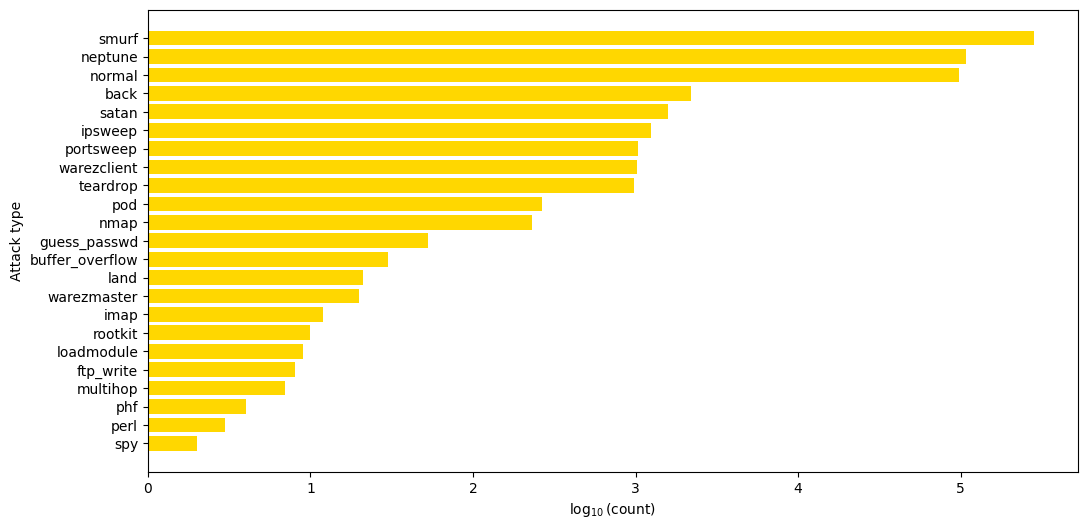

In [8]:
plt.figure(figsize=(12, 6))
plt.barh(ypos, np.log10(counts), facecolor="gold")
plt.yticks(ypos, labels=[a.decode("utf-8")[0:-1] for a in attacks])
plt.xlabel(r"$\log_{10}(\mathrm{count})$")
plt.ylabel("Attack type")
plt.show()

## Start on k-means basic algo

In [10]:
index_udf = udf(lambda row:attacks.tolist().index(row) )
kdd = kdd.withColumn("labels", index_udf(col("labels")).cast("int"))

In [11]:
ignored_cols = ["labels", "centr", "cost", "p", "w"]

In [12]:
kdd = kdd.withColumn("centr", lit(-1))
kdd = kdd.withColumn("cost", lit(0.))
kdd = kdd.withColumn("p", lit(0.))

ncols = len([c for c in kdd.columns if c not in ignored_cols])

In [13]:
kdd

DataFrame[duration: double, src_bytes: double, dst_bytes: double, land: double, wrong_fragment: double, urgent: double, hot: double, num_failed_logins: double, logged_in: double, num_compromised: double, root_shell: double, su_attempted: double, num_root: double, num_file_creations: double, num_shells: double, num_access_files: double, num_outbound_cmds: bigint, is_host_login: bigint, is_guest_login: double, count: double, srv_count: double, serror_rate: double, srv_serror_rate: double, rerror_rate: double, srv_rerror_rate: double, same_srv_rate: double, diff_srv_rate: double, srv_diff_host_rate: double, dst_host_count: double, dst_host_srv_count: double, dst_host_same_srv_rate: double, dst_host_diff_srv_rate: double, dst_host_same_src_port_rate: double, dst_host_srv_diff_host_rate: double, dst_host_serror_rate: double, dst_host_srv_serror_rate: double, dst_host_rerror_rate: double, dst_host_srv_rerror_rate: double, labels: int, centr: int, cost: double, p: double]

In [14]:
def dist(x,y):
    try:
        #return (((np.array(x)-y)**2).sum())**0.5
        return np.linalg.norm(np.array(x)-np.array(y))
    except Exception as e:
        print(e)
        return ncols

def argcomp(comp,func, arr, *params):
    res = [func(arr[i], *params) for i in range(len(arr))]
    #print(res)
    return res.index(comp(res))


### Lloyd Iteration

In [15]:
def kmeans(data, centers, max_iter=100, weighted=False, local_centr=False, return_cost=False):
    count = 0
    
    
    cols = data.columns
    
    cost = float("inf")
    
    while count<=max_iter:
        if local_centr:
            cc = centers
            local_centr = False
        else:
            cc = centers.collect()
        #print(cc)
        
        ## set center affiliation
        argmindist_udf = udf(lambda row: argcomp(min,dist,cc,row), IntegerType())
        data = data.withColumn("centr", argmindist_udf(array([c for c in cols if c not in ignored_cols])))
        
        ## calculate new centers
        if not weighted:
            centers = data.groupBy("centr").mean().select(*[col("avg("+c+")") for c in data.columns if c not in ignored_cols])
        else:
            centers = data.rdd.map(
                lambda x: (x["centr"],(np.array([x[c] for c in cols if c not in ignored_cols]),x["w"]))
            ).reduceByKey(
                lambda x,y: ((x[0]*x[1]+y[0]*y[1])/(x[1]+y[1]), x[1]+y[1])
            ).map(lambda x: x[1][0])
        
        get_cost = udf(lambda row: str(min([dist(row, cen)**2 for cen in cc])))
        
        data = data.withColumn("cost", get_cost(array([c for c in cols if c not in ignored_cols])).cast("double"))
        newcost = data.select("cost").groupBy().sum().collect()[0][0]
        
        count+=1
        if newcost/cost>0.99:
            break
        
        cost=newcost
            
    if return_cost:
        return data, centers, cost
    else:
        return data, centers

### stupid init
###### stupid, innit?

In [17]:
def uniform_init(k, mn=0, mx=1):
    return pd.DataFrame(np.random.random(size=(k, ncols))*(mx-mn) - mn)

In [21]:
unif_data, _ = kmeans(kdd, uniform_init(len(attacks)), local_centr=True)

## K-means||

In [22]:
def kmeans_parallel(data, k, l):
    centr = data.select(array([c for c in data.columns if c not in ignored_cols])).rdd.takeSample(True,2)
    #define get_cost using udf on min(dist(row,centr[i]))
    get_cost = udf(lambda row: str(min([dist(row, cen)**2 for cen in centr])))
    
    data = data.withColumn("cost", get_cost(array([c for c in data.columns if c not in ignored_cols])).cast("double"))
    
    cost = data.select("cost").groupBy().sum().collect()[0][0]
    
    for i in range(int(np.log(cost))):
        #re-define get_cost using udf on min(dist(row,centr[i]))
        get_cost = udf(lambda row: str(min([dist(row, cen)**2 for cen in centr])))
        data = data.withColumn("cost", get_cost(array([c for c in data.columns if c not in ignored_cols])).cast("double"))
        cost = data.select("cost").groupBy().sum().collect()[0][0]
        
        data = data.withColumn("p", udf(lambda row: np.random.random())(col("cost")))
        
        centr.extend( data.where( data["cost"] * l > cost * data["p"]).select(array([c for c in data.columns if c not in ignored_cols])).collect() )
    
    ## search for possible identical centroids ? 
    #should be taken care of thanks to the weighting, I think
    
    if len(centr) > k: 
        #get weights
        data, _ = kmeans(data, centr, max_iter=0, local_centr=True)
        counts = data.groupBy("centr").count().collect()
        counts = sorted(counts)
        
        #parallelize the centroid dataset
        cdata = spark.createDataFrame(pd.DataFrame([[*centr[i][0], counts[i][1]] for i in range(len(centr))], columns=(0,1,"w")))
        cdata = cdata.withColumn("w", col("w").cast("double"))
        
        ## basically kmeans++ on the centroids as init for the weighted k-means
        c = [centr[np.random.randint(len(centr))]]
        for i in range(k-1):
            costs = [min([dist(centr[j], c[k])**2 for k in range(len(c))]) for j in range(len(centr))]
            p = np.cumsum(costs)
            p/= p[-1]
            c.append(centr[(p>np.random.random()).tolist().index(True)])
        
        
        _, centr = kmeans(cdata, c, local_centr=True, weighted=True)
        centr = centr.collect()
    return centr

testdata = np.random.random(size=(300, 2))*2-1
testdata[testdata>=0]+=1
testdata[testdata<0]-=1
testdata

plt.scatter([i[0] for i in testdata], [i[1] for i in testdata])

testdata=spark.createDataFrame(pd.DataFrame(testdata))

c = kmeans_parallel(testdata, 4, 2.5)

In [23]:
c = kmeans_parallel(kdd, len(attacks), 2.5) ## l should be ~ k/log(N*ndim) to allow for an appropriate number of centroids


In [25]:
per_data, _ = kmeans(kdd, c, local_centr=True)

colors=["black", "green", "red", "blue"]
plt.scatter([d[0] for d in data_k_l], [d[1] for d in data_k_l], color=[colors[d["centr"]] for d in data_k_l], s=2)
plt.scatter([d[0] for d in c_k], [d[1] for d in c_k], color="orange", s=20)

## Mini-batch k-means

In [28]:
def mini_b(data,batch_size,n_cent,l_rate=0.05,max_it=None):
    if max_it is None:
        max_it = int(2/batch_size) #standard (is it?) amount of iterations
    
    #first centroids initialization
    initialCentroids = data.sample(batch_size).limit(n_cent).select(*[col(c) for c in data.columns if c not in ignored_cols])
    initialCentroids = np.array(initialCentroids.collect())
    
    miniBatch = data.sample(batch_size)
    _, _, cost = kmeans(miniBatch,initialCentroids, local_centr=True, max_iter=0, return_cost=True)
    
    #centroids update
    for _ in range(max_it):
        miniBatch = data.sample(batch_size)
        
        _,newCentroids, newcost = kmeans(miniBatch,initialCentroids, local_centr=True, max_iter=5, return_cost=True)
        
        newCentroids = np.array(newCentroids.collect())
        
        #sort centroids to minimize reciprocal distance by finding the optimal permutation on newCentroids
        
        distances = np.linalg.norm(initialCentroids[:, np.newaxis] - newCentroids, axis=2)
        permutation = np.argmin(np.sum(distances, axis=0))
        newCentroids = newCentroids[permutation]
        
        initialCentroids = (1-l_rate) * initialCentroids + newCentroids * l_rate
        
        if newcost/cost>0.99:
            break
        else:
            cost=newcost

    return initialCentroids

In [29]:
newcenters = mini_b(kdd,0.2,len(attacks),0.05,10)

In [30]:
mini_data,_=kmeans(kdd,newcenters, local_centr=True)

##### check results
#print(d, len(d))
mat = [[0 for i in range(4)] for j in range(4)]
for i in range(4):
    for j in range(4):
        for k in range(len(d)):
            mat[i][j] += ((d[k]["labels"] == i) and (d[k]["centr"] == j))
mat

In [83]:
u_data = unif_data.select("labels", "centr").groupBy("labels", "centr").count().collect()
p_data = per_data.select("labels", "centr").groupBy("labels", "centr").count().collect()
m_data = mini_data.select("labels", "centr").groupBy("labels", "centr").count().collect()

In [84]:
u_mat = np.zeros(shape= ((np.max(u_data, axis=0)+1)[0:2]).tolist())
p_mat = np.zeros(shape= ((np.max(p_data, axis=0)+1)[0:2]).tolist())
m_mat = np.zeros(shape= ((np.max(m_data, axis=0)+1)[0:2]).tolist())

In [85]:
for d in u_data:
    u_mat[d[0]][d[1]]=d[2]

for d in p_data:
    p_mat[d[0]][d[1]]=d[2]

for d in m_data:
    m_mat[d[0]][d[1]]=d[2]


for i in range(len(u_mat)):
    u_mat[i]/= sum(u_mat[i])

for i in range(len(p_mat)):
    p_mat[i]/= sum(p_mat[i])

for i in range(len(m_mat)):
    m_mat[i]/= sum(m_mat[i])

#u_mat=np.log10(u_mat)
#p_mat=np.log10(p_mat)
#m_mat=np.log10(m_mat)

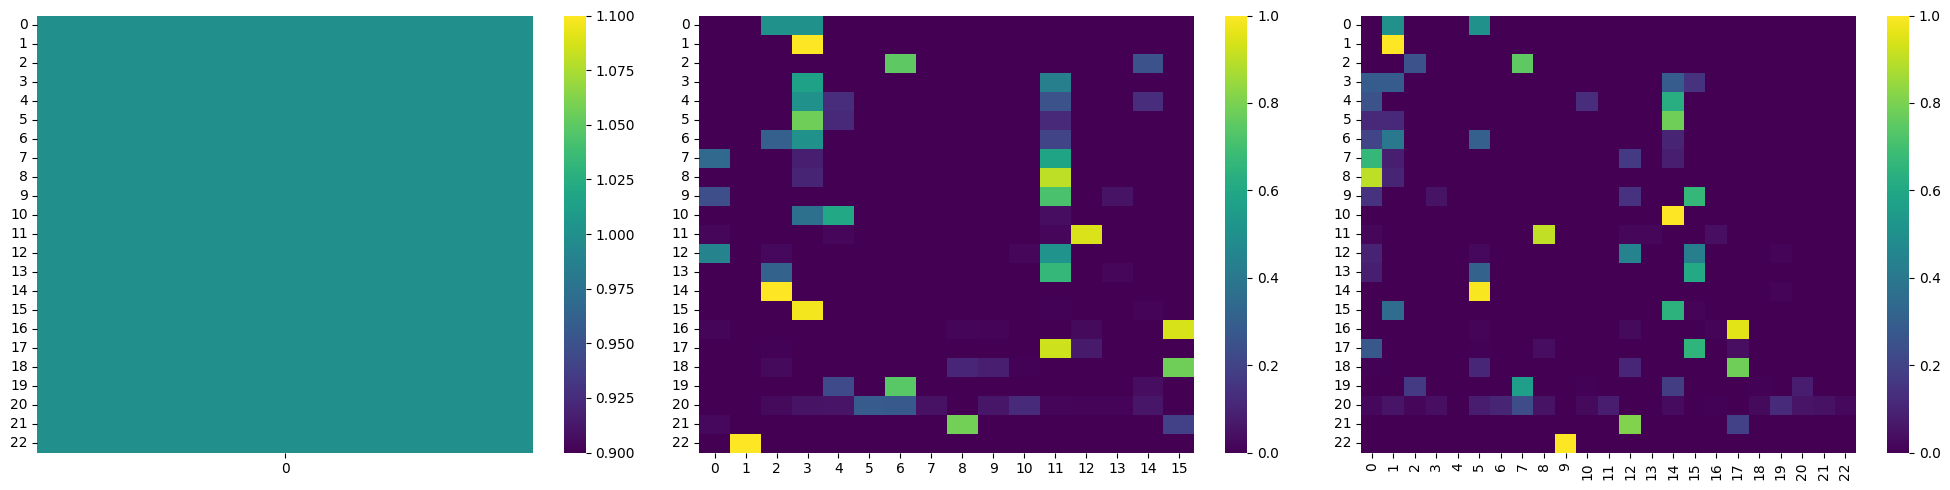

In [87]:
fig, ax=plt.subplots(ncols=3, figsize=(20,5))
sns.heatmap(u_mat, ax=ax[0], cmap="viridis")
sns.heatmap(p_mat, ax=ax[1], cmap="viridis")
sns.heatmap(m_mat, ax=ax[2], cmap="viridis")
fig.tight_layout()

## Close session

In [88]:
sc.stop()
spark.stop()